# Fantasy Football Running Back Predictions

This project explores predicting fantasy football performance for NFL running backs using historical statistics from a kaggle dataset and machine learning models.  
The focus is on non-rookie running backs, since their past performance provides meaningful features for prediction.

---

## Project Goals
- Analyze historical fantasy football data for NFL running backs.  
- Engineer features that capture player performance trends across seasons.  
- Build machine learning models to predict future fantasy performance.  
- Compare model predictions against ESPN’s preseason rankings.  
- Generate projected top running back rankings for upcoming seasons.

---

## Data & Methods
- **Data sources:** Historical fantasy stats (`fantasy_data.csv`) and ESPN preseason projections (`ESPN{year}.csv`).  
- **Feature Engineering:**
  - Previous year fantasy points
  - Rolling averages over past 2–3 years
  - Missed games
  - Age and years in league
  - Touches (rush attempts + receptions)
- **Models:** Random Forest Regressor, with Linear Regression tested for comparison.  
- **Evaluation:** Model predictions are compared against:
  - Actual fantasy performance
  - ESPN preseason rankings using average ranking error as the main metric.

---

## Predictions
- Running backs tend to have short careers, with production peaking early.  
- Fantasy performance generally declines after a few seasons in the league.
- For 2023 and 2024, the model’s predicted RB ranks are compared directly to ESPN’s projections and actual outcomes.
- A 2025 top 20 non-rookie RB ranking is generated using the most recent available data.  

---

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.ensemble import RandomForestRegressor

### Running Back Career Lengths

This chart shows the **distribution of NFL running back career lengths**, measured in number of seasons played.  
It highlights that most RBs have relatively short careers, which is an important factor when building predictive models for fantasy football performance.

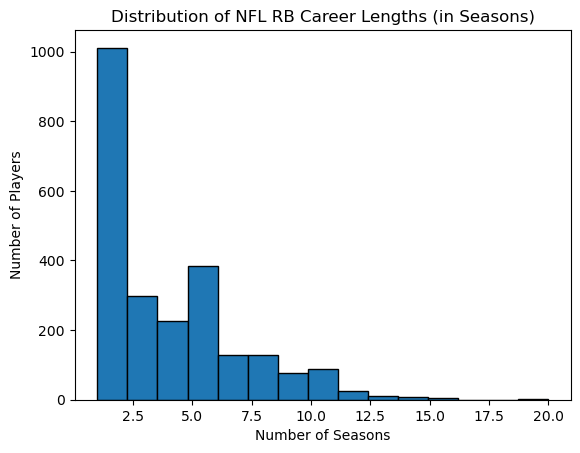

In [2]:
fantasy_stats = pd.read_csv("data/fantasy_data.csv")
rbs = fantasy_stats[fantasy_stats["Pos"] == "RB"].copy()
career_lengths = rbs.groupby("Player")["Year"].nunique()
plt.hist(career_lengths, bins=15, edgecolor="black")
plt.title("Distribution of NFL RB Career Lengths (in Seasons)")
plt.xlabel("Number of Seasons")
plt.ylabel("Number of Players")
plt.show()

### Average Rushing Yards by Age

This chart shows the **average rushing yards per season by running back age**.  
It provides insight into how performance typically peaks in the mid-20s before declining, which motivates including **age** as a predictive feature.

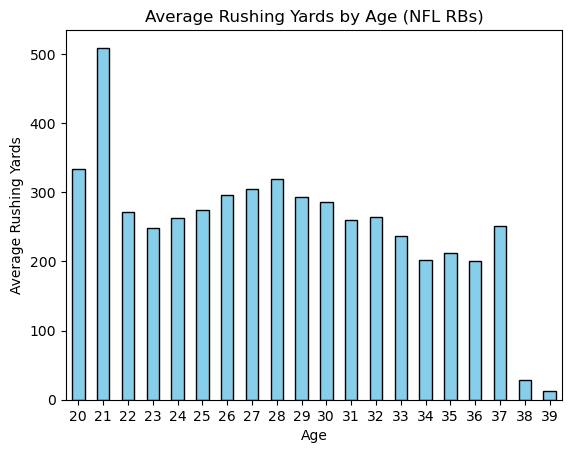

In [3]:
avg_by_age = rbs.groupby("Age")["Rush_Yds"].mean()
avg_by_age.plot(kind="bar", color="skyblue", edgecolor="black")
plt.title("Average Rushing Yards by Age (NFL RBs)")
plt.xlabel("Age")
plt.ylabel("Average Rushing Yards")
plt.xticks(rotation=0)
plt.show()

### Fantasy Points Distribution for Starter RBs

We filter to starter running backs (those with at least 12 games played in a season),  
calculate their fantasy points using Non-PPR scoring rules, and plot the distribution of fantasy production.  
This gives a baseline view of how RBs typically perform in fantasy football.

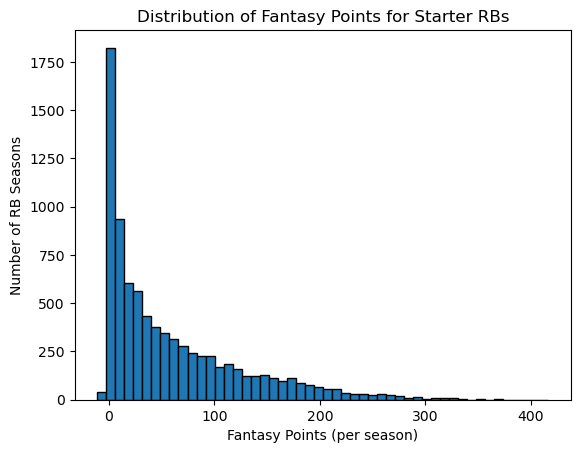

In [4]:
# Filter for starter RBs (played >12 games in a season)
starters_flag = rbs.groupby("Player")["games_started_pct"].max().reset_index()
starters_flag = starters_flag[(rbs.groupby("Player")["G"].max().reset_index()["G"] > 12)]
starters = rbs[rbs["Player"].isin(starters_flag["Player"])].copy()

# Compute fantasy points (standard scoring)
starters["fantasy_points"] = (
    starters["Rush_Yds"] / 10
    + starters["Rec_Yds"] / 10
    + starters["Rush_TD"] * 6
    + starters["Rec_TD"] * 6
    - starters["FmbLost"] * 2
)

# Plot distribution of fantasy points for starter RBs
plt.hist(starters["fantasy_points"], bins=50, edgecolor="black")
plt.xlabel("Fantasy Points (per season)")
plt.ylabel("Number of RB Seasons")
plt.title("Distribution of Fantasy Points for Starter RBs")
plt.show()

### Fantasy Points Distribution by Career Year

We track each player's career year and visualize the distribution of fantasy points for each year.  
This shows how running back production changes over the course of a typical career.

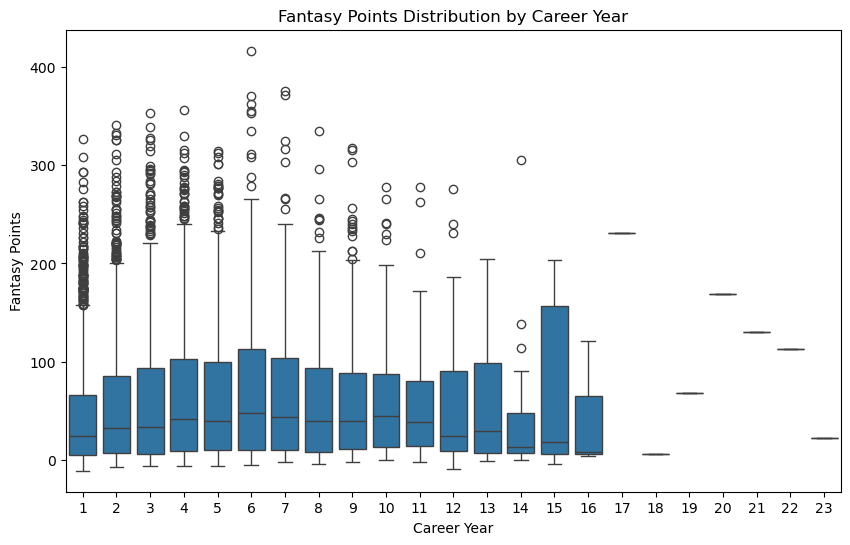

In [14]:
starters["career_year"] = starters.groupby("Player").cumcount() + 1
plt.figure(figsize=(10,6))
sns.boxplot(x="career_year", y="fantasy_points", data=starters)
plt.title("Fantasy Points Distribution by Career Year")
plt.xlabel("Career Year")
plt.ylabel("Fantasy Points")
plt.show()

### Data Preprocessing  
We create lag features (previous season’s fantasy points, rushing attempts, receptions, etc.)  
as well as contextual features like age, years in league, and missed games.  

These features let the model capture both player history and player context.  

In [8]:
def preprocess_starters(starters):
    starters = starters.sort_values(["Player", "Year"]).reset_index(drop=True)
    starters["fantasy_prev"] = starters.groupby("Player")["fantasy_points"].shift(1)
    starters["rush_att_prev"] = starters.groupby("Player")["Rush_Att"].shift(1)
    starters["rec_prev"] = starters.groupby("Player")["Rec_Rec"].shift(1)
    starters["touches_prev"] = starters["rush_att_prev"] + starters["rec_prev"]
    starters["fantasy_avg_2"] = starters.groupby("Player")["fantasy_points"].transform(
        lambda x: x.shift(1).rolling(2).mean())
    starters["fantasy_avg_3"] = starters.groupby("Player")["fantasy_points"].transform(
        lambda x: x.shift(1).rolling(3).mean())
    starters["fantasy_diff_1"] = starters["fantasy_prev"] - starters.groupby("Player")["fantasy_points"].shift(2)
    starters["age"] = starters["Age"]
    starters["years_in_league"] = starters.groupby("Player").cumcount() + 1
    starters["games_prev"] = starters.groupby("Player")["G"].shift(1)
    starters["max_games"] = starters["Year"].apply(lambda x: 17 if x >= 2021 else 16)
    starters["missed_games_prev"] = starters["max_games"] - starters.groupby("Player")["G"].shift(1)
    return starters.copy()

### Yearly Comparison to ESPN Projections  
This function trains the model on all seasons before a given year,  
predicts fantasy points for the given year, and compares the model’s ranking  
to both the actual rankings and ESPN’s preseason projections.  

It outputs a styled table with:  
- Player name  
- Model rank vs ESPN rank vs actual rank  
- Error comparison (our model vs ESPN)  
- Average error across top 20 RBs  

In [9]:
def make_yearly_comparison(starters_model, prediction_year, features, espn_path_template="data/ESPN{}.csv"):
    """
    Trains a linear regression model on all years < prediction_year,
    predicts fantasy points for prediction_year, compares to ESPN projections,
    and returns a styled table with ranking comparison and average error.
    """

    # -------------------------------
    # 1. Train/test split
    # -------------------------------
    data = starters_model.dropna(subset=features + ["fantasy_points"])
    train = data[data["Year"] < prediction_year]
    test = data[data["Year"] == prediction_year]
    X_train, y_train = train[features], train["fantasy_points"]
    X_test, y_test = test[features], test["fantasy_points"]

    # -------------------------------
    # 2. Fit Linear Regression model
    # -------------------------------
    rf = RandomForestRegressor(n_estimators=200, max_depth=8, random_state=42)
    rf.fit(X_train, y_train)
    test = test.copy()
    test["predicted_fp"] = rf.predict(X_test)
    test["predicted_rank"] = test["predicted_fp"].rank(ascending=False, method="min").astype(int)
    test_non_rookies = test[test["years_in_league"] > 1].copy()
    test_non_rookies["actual_rank"] = test_non_rookies["fantasy_points"].rank(ascending=False, method="min").astype(int)

    # -------------------------------
    # 3. Merge ESPN projections
    # -------------------------------
    espn = pd.read_csv(espn_path_template.format(prediction_year))
    espn["Player"] = espn["Player"].str.strip()
    test_non_rookies["Player"] = test_non_rookies["Player"].str.strip()
    test_non_rookies = test_non_rookies.merge(espn[["Player","Pred_Rank"]], on="Player", how="left")
    test_non_rookies.rename(columns={"Pred_Rank": "espn_rank"}, inplace=True)
    test_non_rookies["espn_rank_filled"] = test_non_rookies["espn_rank"].fillna(86)

    # -------------------------------
    # 4. Compute errors
    # -------------------------------
    test_non_rookies["your_error"] = (test_non_rookies["predicted_rank"] - test_non_rookies["actual_rank"]).abs()
    test_non_rookies["espn_error"] = (test_non_rookies["espn_rank_filled"] - test_non_rookies["actual_rank"]).abs()
    top_actual = test_non_rookies[test_non_rookies["actual_rank"] <= 20].copy()

    # -------------------------------
    # 5. Build table
    # -------------------------------
    table = top_actual[[
        "Player", "predicted_rank", "espn_rank", "actual_rank", "your_error", "espn_error"
    ]].rename(columns={
        "predicted_rank": "Your Rank",
        "espn_rank": "ESPN Rank",
        "actual_rank": "Actual Rank",
        "your_error": "Your Error",
        "espn_error": "ESPN Error"
    }).sort_values("Actual Rank").reset_index(drop=True)

    # Convert ESPN Rank to integers where possible, otherwise "unranked"
    table["ESPN Rank"] = table["ESPN Rank"].fillna("unranked")
    table.loc[table["ESPN Rank"] != "unranked", "ESPN Rank"] = table.loc[table["ESPN Rank"] != "unranked", "ESPN Rank"].astype(int)

    # Cast errors to int for players
    table.loc[table["Player"] != "Average Error", ["Your Error", "ESPN Error"]] = (
        table.loc[table["Player"] != "Average Error", ["Your Error", "ESPN Error"]].astype(int)
    )

    # Compute average errors
    avg_your_error = table.loc[table["Player"] != "Average Error", "Your Error"].mean()
    avg_espn_error = table.loc[table["Player"] != "Average Error", "ESPN Error"].mean()

    summary_row = pd.DataFrame([{
        "Player": "Average Error",
        "Your Rank": "",
        "ESPN Rank": "",
        "Actual Rank": "",
        "Your Error": round(avg_your_error, 2),
        "ESPN Error": round(avg_espn_error, 2)
    }])

    table_with_summary = pd.concat([table, summary_row], ignore_index=True)

    # -------------------------------
    # 6. Styling function
    # -------------------------------
    def highlight_winner(row):
        colors = [''] * len(row)
        if row["Player"] == "Average Error":
            if row["Your Error"] < row["ESPN Error"]:
                colors[4] = 'background-color: lightgreen'
                colors[5] = 'background-color: lightcoral'
            elif row["Your Error"] > row["ESPN Error"]:
                colors[4] = 'background-color: lightcoral'
                colors[5] = 'background-color: lightgreen'
            else:
                colors[4] = colors[5] = 'background-color: khaki'
        else:
            if row["ESPN Rank"] == "unranked":
                colors[1] = 'background-color: lightgreen'
                colors[2] = 'background-color: lightcoral'
                colors[4] = 'background-color: lightgreen'
                colors[5] = 'background-color: lightcoral'
            elif row["Your Error"] < row["ESPN Error"]:
                colors[1] = 'background-color: lightgreen'
                colors[2] = 'background-color: lightcoral'
                colors[4] = 'background-color: lightgreen'
                colors[5] = 'background-color: lightcoral'
            elif row["Your Error"] > row["ESPN Error"]:
                colors[1] = 'background-color: lightcoral'
                colors[2] = 'background-color: lightgreen'
                colors[4] = 'background-color: lightcoral'
                colors[5] = 'background-color: lightgreen'
            else:
                colors[1] = colors[2] = colors[4] = colors[5] = 'background-color: khaki'
        return colors
    return table_with_summary.style.apply(highlight_winner, axis=1).hide(axis='index')

### Future Year Prediction  
This function predicts running back fantasy points for an upcoming season  
using player stats from the most recent completed season.  

For example, when predicting 2025, the model is trained on all years up to 2024  
and makes predictions for players based on their 2024 stats.  

In [10]:
def predict_future_year(starters_model, prediction_year, features, top_n=20):
    """
    Train on all years < prediction_year, predict fantasy points for players
    from the last available season (prediction_year - 1).
    """
    data = starters_model.dropna(subset=features + ["fantasy_points"])

    # Train on everything up to year before prediction_year
    train = data[data["Year"] < prediction_year]
    last_season = data[data["Year"] == prediction_year - 1]

    X_train = train[features]
    y_train = train["fantasy_points"]

    X_test = last_season[features]

    # Train model
    rf = RandomForestRegressor(n_estimators=200, max_depth=8, random_state=42)
    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_test)


    test = last_season.copy()
    test["predicted_fp"] = y_pred
    test["Predicted Rank"] = test["predicted_fp"].rank(ascending=False, method="min").astype(int)

    # Keep only player + rank
    top_predicted = (
        test.sort_values("Predicted Rank")
            .head(top_n)[["Player", "Predicted Rank"]]
            .reset_index(drop=True)
    )
    return top_predicted.style.hide(axis="index")

### Running the Model  
We preprocess the starter data, define features (including a rookie flag),  
and train the Random Forest model.  

Below we generate predictions and comparison tables for the 2023 season.  

In [11]:
# Preprocess data
starters_model = preprocess_starters(starters)

lag_features = ["fantasy_prev", "rush_att_prev", "rec_prev", "touches_prev",
                "fantasy_avg_2", "fantasy_avg_3", "fantasy_diff_1", "games_prev", "missed_games_prev"]

# Add rookie flag
starters_model["is_rookie"] = (starters_model["years_in_league"] == 1).astype(int)

# Use Random Forest with lag features as-is
features = ["fantasy_prev", "rush_att_prev", "rec_prev", "touches_prev",
            "fantasy_avg_2", "fantasy_avg_3", "fantasy_diff_1",
            "age", "years_in_league", "games_prev", "missed_games_prev",
            "is_rookie"]

# Fill missing lag features with 0 only for non-rookies
starters_model.loc[starters_model["is_rookie"] == 0, lag_features] = \
    starters_model.loc[starters_model["is_rookie"] == 0, lag_features].fillna(0)


table_2023 = make_yearly_comparison(starters_model, 2023, features)

table_2023  # displays the styled comparison for 2023

Player,Your Rank,ESPN Rank,Actual Rank,Your Error,ESPN Error
Christian McCaffrey,1,3.000000,1,0.000000,2.000000
Raheem Mostert,38,35.000000,2,36.000000,33.000000
Kyren Williams,58,49.000000,3,55.000000,46.000000
Travis Etienne,24,8.000000,4,20.000000,4.000000
Joe Mixon,9,9.000000,5,4.000000,4.000000
Breece Hall,42,16.000000,6,36.000000,10.000000
Derrick Henry,4,1.000000,7,3.000000,6.000000
Rachaad White,49,17.000000,8,41.000000,9.000000
David Montgomery,21,26.000000,9,12.000000,17.000000
James Cook,48,22.000000,10,38.000000,12.000000


In [12]:
table_2024 = make_yearly_comparison(starters_model, 2024, features)
table_2024

Player,Your Rank,ESPN Rank,Actual Rank,Your Error,ESPN Error
Derrick Henry,26,7.000000,1,25.000000,6.000000
Saquon Barkley,10,5.000000,2,8.000000,3.000000
Jahmyr Gibbs,11,8.000000,3,8.000000,5.000000
Bijan Robinson,8,2.000000,4,4.000000,2.000000
Josh Jacobs,2,12.000000,5,3.000000,7.000000
Kyren Williams,18,6.000000,6,12.000000,0.000000
James Cook,13,14.000000,7,6.000000,7.000000
Jonathan Taylor,14,4.000000,8,6.000000,4.000000
De'Von Achane,9,17.000000,9,0.000000,8.000000
Joe Mixon,17,15.000000,10,7.000000,5.000000


## 2025 Non-Rookie Running Back Ranking Predictions

In [13]:
top20_2025 = predict_future_year(starters_model, 2025, features, top_n=20)
top20_2025

Player,Predicted Rank
Josh Jacobs,1
Bijan Robinson,2
Jahmyr Gibbs,3
Derrick Henry,4
Saquon Barkley,5
De'Von Achane,6
Jonathan Taylor,7
Breece Hall,8
Rachaad White,9
Travis Etienne,10


## Limitations of This Project

While the model shows promise, there are several challenges that limit accuracy and make fantasy football prediction inherently difficult:

- **Rookie unpredictability** – A large share of fantasy success comes from first-year players, who have no past NFL stats. No matter the model, predicting breakout rookies is inherently noisy.  

- **Non-linear, context-driven outcomes** – Fantasy production depends on many factors outside this dataset, including:  
  - Offensive line quality  
  - Coaching scheme (run-heavy vs pass-heavy)  
  - Injuries, touches, and game script  
  - Competition at the position  
  Even a perfect statistical model can’t fully capture these dynamics.  

- **Limited sample size** – The dataset covers only a few hundred RB seasons. More complex models often overfit on such a small dataset, reducing predictive power.  